# Application 3: a simple nested cube 

In [1]:
import bempp.api
print(bempp.api.__version__)

3.3.5


In [2]:
KI = 1
KE = 1
KW = 1 # try with e.g. 2+1j or 2+0.1j or 2+0.01j (stronger to weaker absorption)
       # with a strong absorption of the wall, the signal within the cavity is weak
MU = 1

ELEMENT_SIZE = 0.5

LENGTH_CAVITY = 1
LENGTH_WALL = 2

DOMAIN_OP = "RWG"
RANGE_OP  = "BC" # Use RWG as a dummy variable when 
                  #   not using BEMPP's built-in strong form
                  # Use BC when using built in assemblers
                  #   (but is slower/more expensive)
DTR_OP    = "SNC"

DOMAIN_M  = "BC"
RANGE_M   = "BC"  # Same as above
DTR_M     = "B-SNC"

DOMAIN_P  = "BC"
RANGE_P   = "BC" # Same as above
DTR_P     = "RBC"

DOMAIN_MP  = "B-RWG"
RANGE_MP   = "B-RWG" # Same as above
DTR_MP     = "RBC"


# The type of space. Currently, the following types
# are supported:
#     "P" : Continuous and piecewise polynomial functions.
#     "DP" : Discontinuous and elementwise polynomial functions.
#     "RT": Raviart-Thomas Vector spaces.
#     "RWG": RWG Vector spaces.
#     "NC": Nedelec Vector spaces.
#     "SNC": Scaled Nedelec Vector spaces. The Nedelec basis functions
#            are scaled with the edge length so that they are identical
#            to RWG functions crossed with the element normals.

#     "B-P": Polynomial spaces on barycentric grids.
#     "B-DP": Polynomial discontinuous spaces on barycentric grids.
#     "B-RT": Raviart-Thomas Vector spaces on barycentric grids.
#     "B-RWG": RWG Vector spaces on barycentric grids.
#     "B-NC": Nedelec Vector spaces on barycentric grids.
#     "B-SNC": Scaled Nedelec Vector spaces on barycentric grids.

#     "DUAL": Dual space on dual grid (only implemented for constants).
#     "BC": Buffa-Christian Vector space.
#     "RBC": Rotated Buffa-Christian Vector space of curl-conforming
#            functions.

In [3]:
import time
from collections import namedtuple
import numpy as np
import bempp.api

from bempp.api import shapes
from bempp.api import function_space, assembly
from bempp.api.operators.boundary import maxwell
from bempp.api.operators.potential import maxwell as maxwell_potential


from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

bempp.api.set_ipython_notebook_viewer()

# Create Grid

In [74]:
methods = [
    DOMAIN_OP, 
    RANGE_OP, 
    DTR_OP,    
    DOMAIN_M, 
    RANGE_M  ,
    DTR_M     ,
    DOMAIN_P  ,
    RANGE_P, 
    DTR_P, 
    DOMAIN_MP,
    RANGE_MP,
    DTR_MP
]

def discretize(grid, *methods_list):
    """
    Returns a named tuple containing the discretised boundaries of the
    given grid according to the method specified.
    """
    space = {}
    methods = list(set(methods_list))
    assert len(methods) > 0, "You must provide disretisation methods."
    for method_key in methods:
        method = method_key.split(".")[0]
        space[method_key] = function_space(grid, method, 0)
    return space


small_cube = discretize(
    shapes.cube(
            length=LENGTH_CAVITY, h=ELEMENT_SIZE,
            origin=(-LENGTH_CAVITY/2, -LENGTH_CAVITY/2, -LENGTH_CAVITY/2)
        ),
    *methods
)


large_cube = discretize(
    shapes.cube(
        length=LENGTH_WALL, h=ELEMENT_SIZE,
        origin=(-LENGTH_WALL/2, -LENGTH_WALL/2, -LENGTH_WALL/2)
    ),
    *methods
)

# Build the Operator (manually)

In [5]:
def to_block_op(mfie, efie, k, mu):
    """
    Build the standard block operator from the given integral equations.
    """
    A = assembly.BlockedOperator(2, 2) # empty operator object
    A[0,0] = mfie
    A[0,1] = mu/k * efie
    A[1,0] = -k/mu * efie
    A[1,1] = mfie
    return A


def get_simple_block_op(space, k, mu, domain, range_, dtr):
    """
    Return a 2x2 block operator defining the block matrix that would
    act on the given grid.
    
    This is similar to the `multitrace_operator` constructor, but it
    allows us to specify exactly which boundary disretisation functions
    to use.
    """
    efie = maxwell.electric_field(
        space[domain], space[range_], space[dtr], k,
    )
    mfie = maxwell.magnetic_field(
        space[domain], space[range_], space[dtr], k,
    )
    A = to_block_op(mfie, efie, k, mu)
    return A


def get_mixed_block_op(target, source, k, mu, domain, range_, dtr):
    """
    Return a 2x2 block operator that defines the interferences on
    `grid_a` by `grid_b`.
    """
    efie = maxwell.electric_field(
        source[domain], target[range_], target[dtr], k
    )
    mfie = maxwell.magnetic_field(
        source[domain], target[range_], target[dtr], k
    )    
    A = to_block_op(mfie, efie, k, mu)
    return A
    

def assign_inplace_subblock(A, a, i, j):
    """
    Assigns the 4 elements of a to the 2x2 block of A
    specified by the indexes i and j.
    """
    bi = 2*i
    bj = 2*j
    A[bi, bj]     = a[0, 0]
    A[bi, bj+1]   = a[0, 1]
    A[bi+1, bj]   = a[1, 0]
    A[bi+1, bj+1] = a[1, 1]
    

def manual_build_PMCHWT_operator(
        small_cube, large_cube, k_int, k_wal, k_ext, mu, parameters,
        domain, range_, dtr
    ):
    """Vector = namedtuple('Vector', ['neumann', 'dirichlet'])
    Build the operator for the nested shape problem formulation.
    """
    # small cube
    A1_1 = get_simple_block_op(small_cube, k_int, mu, domain, range_, dtr)
    Aw_1 = get_simple_block_op(small_cube, k_wal, mu, domain, range_, dtr)
    # large cube
    Aw_w = get_simple_block_op(large_cube, k_wal, mu, domain, range_, dtr)
    Ae_w = get_simple_block_op(large_cube, k_ext, mu, domain, range_, dtr)
    # mixed (target, source, k)
    Aw_1w = get_mixed_block_op(small_cube, large_cube, k_wal, mu, domain, range_, dtr)
    Aw_w1 = get_mixed_block_op(large_cube, small_cube, k_wal, mu, domain, range_, dtr)
   
    # assemble the blocks
    A = assembly.BlockedOperator(2 * 2, 2 * 2)
    assign_inplace_subblock(A, -(Aw_1 + A1_1), 0, 0)
    assign_inplace_subblock(A,   Aw_1w,        0, 1)
    assign_inplace_subblock(A, - Aw_w1,        1, 0)
    assign_inplace_subblock(A,   Aw_w + Ae_w,  1, 1)
    
    return A

    
A1 = manual_build_PMCHWT_operator(
    small_cube, large_cube,
    KI, KW, KE, MU, None,
    DOMAIN_OP, RANGE_OP, DTR_OP
)

# Build the Operator (built-in constructors)

In [6]:
def bempp_build_PMCHWT_operator(
        small_cube, large_cube, k_int, k_wal, k_ext, mu, parameters,
    ):
    small_grid = small_cube[DOMAIN_OP].grid
    large_grid = large_cube[DOMAIN_OP].grid
    
    # small cube
    A1_1 = maxwell.multitrace_operator(small_grid, k_int)
    Aw_1 = maxwell.multitrace_operator(small_grid, k_wal)
    # large cube
    Aw_w = maxwell.multitrace_operator(large_grid, k_wal)
    Ae_w = maxwell.multitrace_operator(large_grid, k_ext)
    # mixed (target, source, k)
#     Aw_1w = get_mixed_block_op(small_cube, large_cube, k_wal, mu)
    Aw_1w = maxwell.multitrace_operator(large_grid, k_wal, target=small_grid) 
#     Aw_w1 = get_mixed_block_op(large_cube, small_cube, k_wal, mu)
    Aw_w1 = maxwell.multitrace_operator(small_grid, k_wal, target=large_grid) 
   
    # assemble the blocks
    A = assembly.BlockedOperator(2 * 2, 2 * 2)
    assign_inplace_subblock(A, -(Aw_1 + A1_1), 0, 0)
    assign_inplace_subblock(A,   Aw_1w,        0, 1)
    assign_inplace_subblock(A, - Aw_w1,        1, 0)
    assign_inplace_subblock(A,   Aw_w + Ae_w,  1, 1)
    
    return A


A2 = bempp_build_PMCHWT_operator(
    small_cube, large_cube,
    KI, KW, KE, MU, None,
)

In [7]:
for space in A2.domain_spaces:
    print(space.global_dof_count)

126
126
390
390


# Build Inverse of Mass Matrix

In [8]:
M = np.empty((2 * 2, 2 * 2), dtype='O')

small_I = bempp.api.operators.boundary.sparse.identity(
    # this can make the kernel crash if not set correctly
#         DOMAIN, RANGE, DUAL_TO_RANGE
    small_cube[DOMAIN_M], small_cube[RANGE_M], small_cube[DTR_M] # function spaces
)
large_I = bempp.api.operators.boundary.sparse.identity(
    # this can make the kernel crash if not set correctly
    large_cube[DOMAIN_M], large_cube[RANGE_M], large_cube[DTR_M] # function spaces
)
inv_small_I = assembly.InverseSparseDiscreteBoundaryOperator(small_I.weak_form())
inv_large_I = assembly.InverseSparseDiscreteBoundaryOperator(large_I.weak_form())

M[0, 0] = inv_small_I
M[1, 1] = inv_small_I
M[2, 2] = inv_large_I
M[3, 3] = inv_large_I

M = bempp.api.assembly.BlockedDiscreteOperator(M)

# Get Mass Matrix from bempp-constructed operator

In [9]:
M2 = np.empty((2 * 2, 2 * 2), dtype='O')



for i in range(4):
    M2[i, i] = assembly.InverseSparseDiscreteBoundaryOperator(
            bempp.api.operators.boundary.sparse.identity(
                A2.range_spaces[i],
                A2.range_spaces[i],
                A2.dual_to_range_spaces[i]
            ).weak_form()
        )

M2 = bempp.api.assembly.BlockedDiscreteOperator(M2)

# Build Preconditioner (manual method)

In [10]:
def build_diagonal(
        small_cube, large_cube,
        k_int, k_wal, k_ext, mu, parameters,
        domain, range_, dtr
    ):
    """
    Assemble the operator which is equivalent to the diagonal of A
    """
    # small cube
    A1_1 = get_simple_block_op(small_cube, k_int, mu, domain, range_, dtr)
    Aw_1 = get_simple_block_op(small_cube, k_wal, mu, domain, range_, dtr)
    # large cube
    Aw_w = get_simple_block_op(large_cube, k_wal, mu, domain, range_, dtr)
    Ae_w = get_simple_block_op(large_cube, k_ext, mu, domain, range_, dtr)
   
    # assemble the blocks
    D = assembly.BlockedOperator(2 * 2, 2 * 2)
    assign_inplace_subblock(D, -(Aw_1 + A1_1), 0, 0)

    assign_inplace_subblock(D,   Aw_w + Ae_w,  1, 1)
    
    return D


D = build_diagonal(
    small_cube, large_cube,
    KI, KW, KE, MU, None,
    DOMAIN_P, RANGE_P, DTR_P
)

# Build Preconditioner (bempp method)

In [11]:
def bempp_diagonal(
        small_cube, large_cube,
        k_int, k_wal, k_ext, mu, parameters
    ):
    small_grid = small_cube[DOMAIN_OP].grid
    large_grid = large_cube[DOMAIN_OP].grid
    
    # small cube
    A1_1 = maxwell.multitrace_operator(small_grid, k_int)
    Aw_1 = maxwell.multitrace_operator(small_grid, k_wal)
    # large cube
    Aw_w = maxwell.multitrace_operator(large_grid, k_wal)
    Ae_w = maxwell.multitrace_operator(large_grid, k_ext)

    # assemble the blocks
    D = assembly.BlockedOperator(2 * 2, 2 * 2)
    assign_inplace_subblock(D, -(Aw_1 + A1_1), 0, 0)

    assign_inplace_subblock(D,   Aw_w + Ae_w,  1, 1)
    
    return D

D2 = bempp_diagonal(
        small_cube, large_cube,
        KI, KW, KE, MU, None,
)

# Discretize the incident field

In [12]:
def incident_field(x):
    return np.array([0. * x[2], 0. * x[2], np.exp(1j * KE * x[0])])


def dirichlet_trace_fun(x, n, domain_index, result):
    result[:] = np.cross(incident_field(x), n)

    
def curl(incident_field,x):
    return np.array([0,  - 1j * KE * np.exp(1j * KE * x[0]), 0])


def neumann_trace_fun(x, n, domain_index, result):
    result[:] = (1/(1j * KE)) * np.cross(curl(incident_field,x), n)

# for large cube
Dtrace_inc = bempp.api.GridFunction(
    large_cube[DOMAIN_OP],
#     large_cube[DUAL_TO_RANGE],
    fun=dirichlet_trace_fun
)
Ntrace_inc = (KE/MU) * bempp.api.GridFunction(
    large_cube[DOMAIN_OP],
#     large_cube[DUAL_TO_RANGE],
    fun=neumann_trace_fun
)
# combine
Vector = namedtuple('Vector', ['dirichlet', 'neumann'])
man_u_inc = Vector(
    Dtrace_inc.coefficients.tolist(),
    Ntrace_inc.coefficients.tolist()
)

In [88]:
A2.domain_spaces

(<bempp.api.space.space.BarycentricRWGSpace at 0x7f49a72129b0>,
 <bempp.api.space.space.BuffaChristiansenSpace at 0x7f49a7206048>)

In [92]:
Dtrace_inc_bempp = bempp.api.GridFunction(
    A2.domain_spaces[2],
#     large_cube[DUAL_TO_RANGE],
    fun=dirichlet_trace_fun
)
Ntrace_inc_bempp = (KE/MU) * bempp.api.GridFunction(
    A2.domain_spaces[3],
#     large_cube[DUAL_TO_RANGE],
    fun=neumann_trace_fun
)

# Assemble RHS (numerical form)

In [14]:
def get_identity_op(space, domain, range_, dtr):
    """
    Shortcut to the sparse identity operator.
    """
    return bempp.api.operators.boundary.sparse.identity(
        # this can make the kernel crash if not set correctly
        space[domain], space[range_], space[dtr]
    )
    
    
def manually_get_block_identity_op(space, domain, range_, dtr):
    """
    Create an identity operator matching the given space.
    """
    i = get_identity_op(space, domain, range_, dtr)
    I = assembly.BlockedOperator(2, 2)
    I[0, 0] = i;
    I[1, 1] = i
    return I
    

Aw_1w = get_mixed_block_op(
    small_cube, large_cube,
    KW, MU,
    DOMAIN_OP, RANGE_OP, DTR_OP
)


Aw_w  = get_simple_block_op(
    large_cube, KW, MU,
    DOMAIN_OP, RANGE_OP, DTR_OP                       
)

I = manually_get_block_identity_op(
    large_cube, DOMAIN_OP, RANGE_OP, DTR_OP)


def flatten(vector):
    return np.array(vector[0] + vector[1])

pre = [
    - Aw_1w.weak_form() * flatten(man_u_inc),
    - (Aw_w.weak_form() - 1/2 * I.weak_form()) * flatten(man_u_inc)
]
# flatten list of lists


b1 = [y for x in pre for y in x]

# Assemble RHS (bempp constructs)

In [93]:
I = bempp.api.operators.boundary.sparse.multitrace_identity(
        large_cube[DOMAIN_OP].grid, spaces='maxwell')

Aw_w = maxwell.multitrace_operator(large_cube[DOMAIN_OP].grid, KW)

Aw_1w = maxwell.multitrace_operator(
    large_cube[DOMAIN_OP].grid, KW, target=small_cube[DOMAIN_OP].grid) 

b2 = [
    - Aw_1w * [Dtrace_inc_bempp, Ntrace_inc_bempp],
    - (Aw_w - 1/2 * I) * [Dtrace_inc_bempp, Ntrace_inc_bempp]
]

b2 = [b2[0][0], b2[0][1], b2[1][0], b2[1][1]]

In [70]:
Dtrace_inc

NotImplementedError

# Solve the Linear System (manually constructed)

In [16]:
options = dict(
    restart=500,
    maxiter=500,
    return_residuals=True
)

## Setup operators

In [17]:
from antigoni.login import gmres

Operator = namedtuple('Operator', ['name', 'lhs', 'rhs'])
Result = namedtuple('Result', ['x', 'info', 'residuals'])

operators = [
    Operator(
       'man-none',  # Name 
        A1.weak_form(), # LHS
        b1 # RHS
    ),
#     Operator(
#        'man-M',
#         M * A1.weak_form(),
#         M * b1
#     ),
#     Operator(
#         'bempp-none',
#         A2.weak_form(),
#         np.hstack([bb.coefficients for bb in b2])
#     ),
#     Operator(
#         'bempp-M',
#         M * A2.weak_form(),
#         M * np.hstack([bb.coefficients for bb in b2])
#     ),
#     Operator(
#         'bempp-M2',
#         M2 * A2.weak_form(),
#         M2 * np.hstack([bb.coefficients for bb in b2])
#     ),
#     Operator(
#         'D2-weak',
#         D2.weak_form() * M2 * A2.weak_form(),
#         D2.weak_form() * M2 * np.hstack([bb.coefficients for bb in b2])
#     ),
    Operator(
        'D2-strong',
        D2.strong_form() * M2 * A2.weak_form(),
        D2.strong_form() * M2 * np.hstack([bb.coefficients for bb in b2])
    )
]

In [18]:
results = {
    op.name: Result(
        *gmres(
            op.lhs, op.rhs,
            **options
        )
    )
    for op in operators
} 

# Solve the System (bempp constructors)

In [94]:
# Strong Form
x, info, residuals = bempp.api.linalg.gmres(
    A2, b2,
    use_strong_form=True,
    **options
)

# x = np.hstack([c.coefficients for c in temp])
results['Built-In Strong'] = Result(x, info, residuals)

In [22]:
x, info, residuals = bempp.api.linalg.gmres(
    A2, b2,
    use_strong_form=False,
    **options
)

# x = np.hstack([c.coefficients for c in x])
results['Built-In Weak'] = Result(x, info, residuals)

# Plot Convergence

In [23]:
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


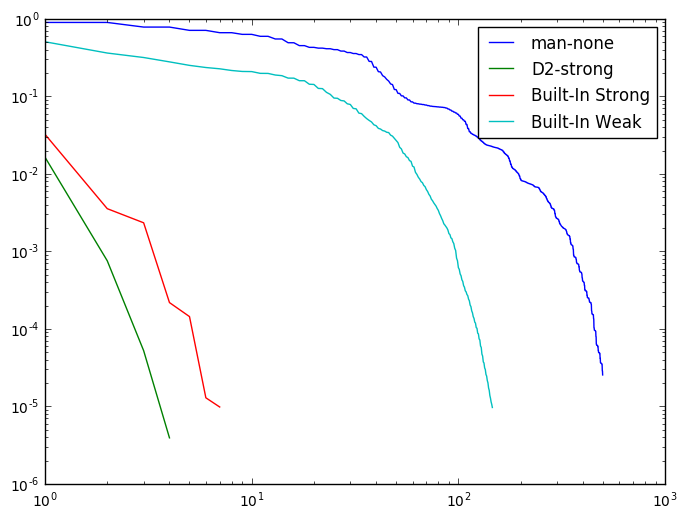

In [95]:
for name, result in results.items():
    if name not in ['man-M']:
        plt.loglog(result.residuals, label=name)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.dpi = 100

# Plot 

In [107]:
PRECON_TYPE = 'Built-In Strong'
is_bempp_constructed = True

# Extract Data (from manual construction)

In [101]:
# x = results[PRECON_TYPE].x
if not is_bempp_constructed:
    small_domain_0 = small_cube[DOMAIN_OP]
    small_domain_1 = small_cube[DOMAIN_OP]
    large_domain_0 = large_cube[DOMAIN_OP]
    large_domain_1 = large_cube[DOMAIN_OP]

    # Split between different domains in vector 
    u_cavity = Vector(
        dirichlet=x[:small_domain_0.global_dof_count],
        neumann=x[small_domain_0.global_dof_count:small_domain_0.global_dof_count*2]
    )

    split_point = small_domain_0.global_dof_count*2

    u_scattered = Vector(
        dirichlet=x[split_point:split_point+large_domain_1.global_dof_count],
        neumann=x[split_point+large_domain_1.global_dof_count:]
    )

    # Check
    def assert_lengths_match(a, b):
        """
        Raise Error if lengths of a and b do not match.
        """
        if isinstance(a, int):
            va = a
        else:
            va = len(a)

        if isinstance(b, int):
            vb = b
        else:
            vb = len(b)

        assert va == vb, "Lengths must match. Got %i and %i." % (va, vb)


    assert_lengths_match(
        sum([len(z) for z in [
            u_cavity.neumann, u_cavity.dirichlet,
            u_scattered.neumann, u_scattered.dirichlet
        ]]),
        b1
    )

    assert_lengths_match(*u_cavity)
    assert_lengths_match(*u_scattered)

    u_wall = Vector(
        man_u_inc.dirichlet + u_scattered.dirichlet,
        man_u_inc.neumann + u_scattered.neumann,
    )


    # Cavity
    Ntrace_i = bempp.api.GridFunction(
        small_domain_1, coefficients=u_cavity.neumann)
    Dtrace_i = bempp.api.GridFunction(
        small_domain_0, coefficients=u_cavity.dirichlet)

    # Wall
    Ntrace_w = bempp.api.GridFunction(
        large_domain_1, coefficients=u_wall.neumann)
    Dtrace_w = bempp.api.GridFunction(
        large_domain_0, coefficients=u_wall.dirichlet)

    # Scattered
    Ntrace = bempp.api.GridFunction(
        large_domain_1, coefficients=u_scattered.neumann)
    Dtrace = bempp.api.GridFunction(
        large_domain_0, coefficients=u_scattered.dirichlet)

else:
    small_domain_0 = A2.domain_spaces[0]
    small_domain_1 = A2.domain_spaces[1]
    large_domain_0 = A2.domain_spaces[2]
    large_domain_1 = A2.domain_spaces[3]
    
    # cavity
    Dtrace_i = x[0]
    Ntrace_i = x[1]
    
    # scattered
    Dtrace = x[2]
    Ntrace = x[3]
    
    # wall
    Dtrace_w = Dtrace_inc_bempp + Dtrace
    Ntrace_w = Ntrace_inc_bempp + Ntrace 
    

In [102]:
# Number of points in the x-direction
nx = 220# divide accordingly to achieve smaller particles

# Number of points in the y-direction
nz = 220

xmin, xmax, zmin, zmax = [
    -LENGTH_WALL/2-1,
    LENGTH_WALL/2+1,
    -LENGTH_WALL/2-1,
    LENGTH_WALL/2+1
] 
# Ask Antigoni, why j's
plot_grid = np.mgrid[xmin:xmax:nx * 1j, 0:0:1j, zmin:zmax:nz * 1j]

c = 0 # Intersecting plane

points = np.vstack((
    plot_grid[0].ravel(),
    c * np.ones(plot_grid[0].size),
    plot_grid[2].ravel()
))

# Compute interior and exterior indices
all_indices = np.ones(points.shape[1], dtype='uint32')

def point_is_within_cube(upper_bound_length, point):
    """
    Determines whether the given point is contained within the a centered cube with the
    bounds specified.
    """
    c =  [-upper_bound_length/2 < px and px < upper_bound_length/2
          for px in point]
    return all(c)

cavity_indexer = []
wall_indexer = []
exterior_indexer = []

for i, point in enumerate(points.T):
    if point_is_within_cube(LENGTH_CAVITY, point):
        cavity_indexer.append(i)
    elif point_is_within_cube(LENGTH_WALL, point):
        wall_indexer.append(i)
    elif point_is_within_cube(np.inf, point):
        exterior_indexer.append(i)
    else:
        raise ValueError("Point %s not within domain" % point)


# Sanity check
print(
    len(cavity_indexer), '+',
    len(wall_indexer), '+',
    len(exterior_indexer), '=',
    sum([
        len(cavity_indexer),
        len(wall_indexer),
        len(exterior_indexer)
    ])
)


2916 + 9184 + 36300 = 48400


In [103]:
# Cavity
cavity_points = points[:, cavity_indexer]

E_potential_op = maxwell_potential.electric_field(
    small_domain_1, cavity_points, KI)
H_potential_op = maxwell_potential.magnetic_field(
    small_domain_0, cavity_points, KI)

cavity_field =  H_potential_op * Dtrace_i + E_potential_op * (MU/KI * Ntrace_i)

In [104]:
# Wall
wall_points = points[:, wall_indexer]

# Influence of external boundary
E_potential_op_w = maxwell_potential.electric_field(
    large_domain_1, wall_points, KW)
H_potential_op_w = maxwell_potential.magnetic_field(
    large_domain_0, wall_points, KW)

# Influence of cavity
E_potential_op_i = maxwell_potential.electric_field(
    small_domain_1, wall_points, KW)
H_potential_op_i = maxwell_potential.magnetic_field(
    small_domain_0, wall_points, KW)

# Putting them together
wall_field = H_potential_op_w * Dtrace_w + E_potential_op_w * (MU/KW * Ntrace_w) \
    - (H_potential_op_i * Dtrace_i + E_potential_op_i * (MU/KI * Ntrace_i))

In [105]:
   # Scattered
exterior_points = points[:, exterior_indexer]

E_potential_op = maxwell_potential.electric_field(
    large_domain_1, exterior_points, KE)
H_potential_op = maxwell_potential.magnetic_field(
    large_domain_0, exterior_points, KE)


scattered_field = - H_potential_op * Dtrace - E_potential_op * (MU/KE * Ntrace)

Built-In Strong


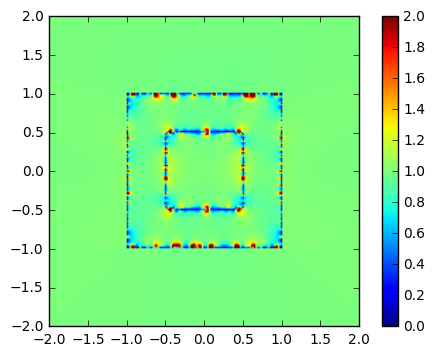

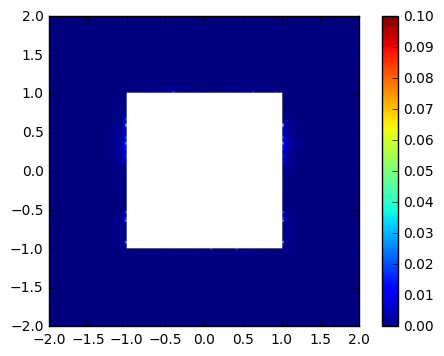

In [108]:
total_field = np.empty_like(points, dtype='complex128')

def get_field(selector, field):
    total_field = np.empty_like(points, dtype='complex128')
    total_field[:] = np.nan
    total_field[:, selector] = field
    return np.sum(np.abs(total_field**2), axis=0)

total_field[:, cavity_indexer] = cavity_field
total_field[:, wall_indexer] =  wall_field
total_field[:, exterior_indexer] = scattered_field + incident_field(points[:, exterior_indexer])
# squared_scattered_field = np.sum(np.abs(scattered_field)**2, axis=0)
squared_field = np.sum(np.abs(total_field**2), axis=0)

print(PRECON_TYPE)

def implot(data, clim=(0, 2)):
    """
    Plot on an axis the field data
    """
    im = plt.imshow(
        data.reshape(nx, nz),
        extent=[xmin, xmax, zmin, zmax],
        clim=clim,
    )
    fig = plt.gcf()
    plt.colorbar()
    fig.dpi = 100
    return x

implot(squared_field);
plt.show()

implot(get_field(exterior_indexer, scattered_field), clim=(0, 0.1));